In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable
from tqdm import tqdm
import pickle

In [ ]:
!gdown --id 1n4VGrcmkyrwLcs6uH6jOQOD7Iy0VEx58
!unzip datasets.zip

Downloading...
From: https://drive.google.com/uc?id=1n4VGrcmkyrwLcs6uH6jOQOD7Iy0VEx58
To: /content/datasets.zip
100% 437M/437M [00:04<00:00, 87.5MB/s]
Archive:  datasets.zip
   creating: datasets/
  inflating: datasets/bow_features   
  inflating: datasets/tfidf_feats_w2v  
  inflating: datasets/tfidf_features  
  inflating: datasets/w2v_words      
  inflating: datasets/X_test_avg_w2v  
  inflating: datasets/X_test_bow     
  inflating: datasets/X_test_tfidf   
  inflating: datasets/X_test_tf_w2v  
  inflating: datasets/X_train_avg_w2v  
  inflating: datasets/X_train_bow    
  inflating: datasets/X_train_tfidf  
  inflating: datasets/X_train_tf_w2v  
  inflating: datasets/y_test         
  inflating: datasets/y_train        


In [ ]:
# loading bow vectors
X_train_bow = pickle.load(open("datasets/X_train_bow","rb"))
X_test_bow = pickle.load(open("datasets/X_test_bow","rb"))
bow_features = pickle.load(open("datasets/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("datasets/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("datasets/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("datasets/tfidf_features","rb"))
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("datasets/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("datasets/X_train_avg_w2v","rb"))
X_test_avgw2v = pickle.load(open("datasets/X_test_avg_w2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("datasets/X_train_tf_w2v","rb"))
X_test_tfw2v = pickle.load(open("datasets/X_test_tf_w2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('datasets/y_train',allow_pickle=True)
y_test = np.load('datasets/y_test',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (275751, 104533)
shape of X_test_bow is (118179, 104533)
shape of X_train_tfidf is (275751, 104533)
shape of X_test_tfidf is (118179, 104533)
shape of X_train_avgw2v is (275751, 50)
shape of X_test_avgw2v is (118179, 50)
shape of X_train_tfw2v is (275751, 50)
shape of X_test_tfw2v is (118179, 50)
shape of y_train is (275751,)
shape of y_test is (118179,)


## Naive Bayes

In [ ]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,X_train,y_train,X_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(X_train))
    cm_test =  confusion_matrix(y_test,model.predict(X_test))
    class_label = ["Negative", "Positive"]
    df_train = pd.DataFrame(cm_train, index=class_label, columns=class_label)
    df_test = pd.DataFrame(cm_test, index=class_label, columns=class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot=True, fmt="d", ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

# helper function to train Logistic Regression and plot Error plots
def naive_bayes(X, y):
    alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    param_grid = {'alpha':alpha}
    nb = MultinomialNB()
    model = GridSearchCV(nb, param_grid, cv=5, return_train_score=True)
    model.fit(X, y)
    print("Model with best parameters :\n",model.best_params_)

    #Plotting
    train_auc = model.cv_results_['mean_train_score'][0:16]
    cv_auc = model.cv_results_['mean_test_score'][0:16]
    plt.grid(True)
    plt.plot(np.log(alpha), train_auc, label='Train AUC')
    plt.plot(np.log(alpha), cv_auc, label='CV AUC')
    plt.scatter(np.log(alpha), train_auc)
    plt.scatter(np.log(alpha), cv_auc)
    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    return model.best_params_

# helper function to plot roc curve for optimal k and plot confusion matrix for both train and test set
def roc_auc_cm(X_train, X_test, y_train, y_test, best_params_):
    alpha = best_params_['alpha']
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train,y_train)
    train_fpr, train_tpr, thresholds = roc_curve(y_train, nb.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)

    plt.grid(True)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(test_auc))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC CURVE FOR OPTIMAL ALPHA")
    plt.show()

    #Area under ROC curve
    print('Area under Train ROC {}'.format(train_auc))
    print('Area under Test ROC {}'.format(test_auc))
    plot_confusion_matrixes(nb, X_train ,y_train, X_test, y_test)

    return nb, train_auc, test_auc

# helper function to display top 10 positive/negative feature
def top_features(nb, features):
    data = nb.coef_.reshape(-1,1)
    df = pd.DataFrame(data,columns=['coefficients'],index=features)
    #Top 10 negative features
    negative = df.sort_values(by='coefficients').head(10)
    #Top 10 positive features
    positive = df.sort_values(by='coefficients',ascending=False).head(10)
    print('Top 10 negative features are: \n {}'.format(negative))
    print('--'*50)
    print('Top 10 positive features are: \n {}'.format(positive))

## Bag of Words

Model with best parameters :
 {'alpha': 1}


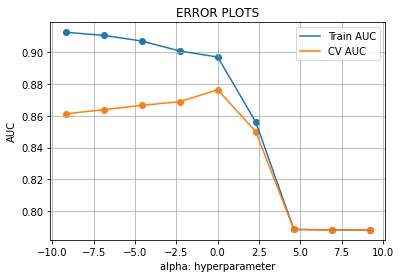

In [ ]:
best_params_ = naive_bayes(X_train_bow, y_train)
alpha_bow = best_params_['alpha']

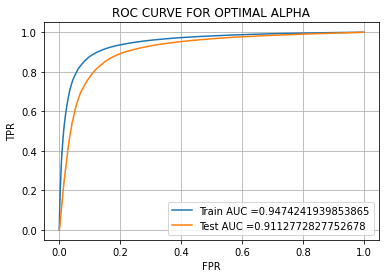

Area under Train ROC 0.9474241939853865
Area under Test ROC 0.9112772827752678


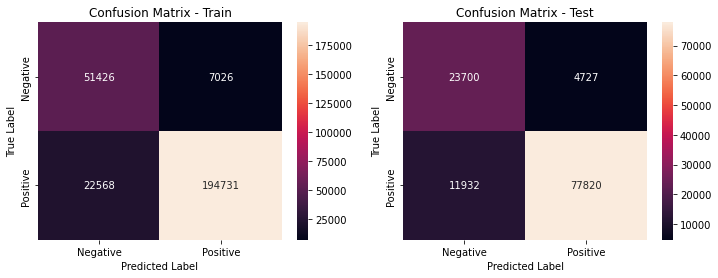

In [ ]:
model, train_auc_bow, test_auc_bow = roc_auc_cm(X_train_bow, X_test_bow, y_train, y_test, best_params_)

In [ ]:
top_features(model, bow_features)

Top 10 negative features are: 
                 coefficients
gramsmagnesium    -16.017099
plantationbell    -16.017099
unbowed           -16.017099
revoir            -16.017099
revocation        -16.017099
cabister          -16.017099
plantiffs         -16.017099
distractingly     -16.017099
plantmatter       -16.017099
unboiled          -16.017099
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
          coefficients
not         -3.777824
great       -4.448181
good        -4.536315
like        -4.612739
tea         -4.949071
one         -4.950008
taste       -4.961411
love        -4.974337
coffee      -5.034233
product     -5.034471


## TF-IDF

Model with best parameters :
 {'alpha': 0.1}


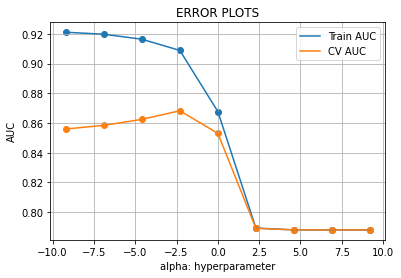

In [ ]:
best_params_ = naive_bayes(X_train_tfidf, y_train)
alpha_tfidf = best_params_['alpha']

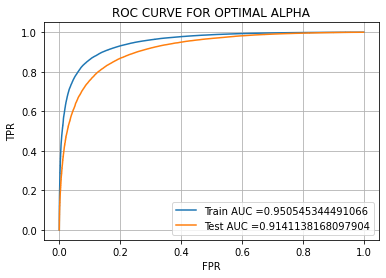

Area under Train ROC 0.950545344491066
Area under Test ROC 0.9141138168097904


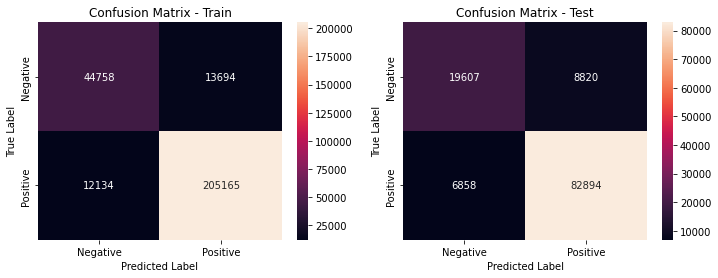

In [ ]:
model, train_auc_tfidf, test_auc_tfidf = roc_auc_cm(X_train_tfidf, X_test_tfidf, y_train, y_test, best_params_)

In [ ]:
top_features(model, tfidf_features)

Top 10 negative features are: 
                coefficients
inaudi           -18.477337
serenyukkitea    -18.477337
candythis        -18.477337
serenditpity     -18.477337
lovesthe         -18.477337
serendipiteas    -18.477337
disappoited      -18.477337
disappoipnted    -18.477337
serated          -18.477337
sequitur         -18.477337
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
          coefficients
not         -4.927247
great       -4.959855
good        -5.147387
tea         -5.246248
coffee      -5.293569
love        -5.330501
like        -5.390336
product     -5.486105
best        -5.492556
taste       -5.558139


Steps:
* Tried out multinomial naive bayes here with bow and tfidf features.
* BOW features model performed slightly better.
* We also able to find out most important features contributing to each model.
* Average-W2V and TFIDF-W2v contain negative values and multinomial naive bayes does not accept negative values.
* Naive bayes can be considered as a baseline model for our problem.

## Observations:

In [ ]:
from prettytable import PrettyTable
    
z = PrettyTable()
z.field_names = ["Vector", "Algorithm", "Hyperparameter-Alpha", "Train AUC", "Test AUC"]
z.add_row(["BOW","Naive Bayes", alpha_bow, train_auc_bow, test_auc_bow])
z.add_row(["TFIDF","Naive Bayes", alpha_tfidf, train_auc_tfidf, test_auc_tfidf])
print(z)

+--------+-------------+----------------------+--------------------+--------------------+
| Vector |  Algorithm  | Hyperparameter-Alpha |     Train AUC      |      Test AUC      |
+--------+-------------+----------------------+--------------------+--------------------+
|  BOW   | Naive Bayes |          1           | 0.9370327086032306 | 0.9155576918303037 |
| TFIDF  | Naive Bayes |         0.1          | 0.950545344491066  | 0.9141138168097904 |
+--------+-------------+----------------------+--------------------+--------------------+
